In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from datetime import datetime

In [830]:
path = "C:/Users/danil/Desktop/Case Mercado Livre/Files/"
file_1 = "ofertas_relampago.csv"
data_1 = pd.read_csv(path+file_1)
df = data_1.copy()
df["OFFER_START_DATE"] = pd.to_datetime(df["OFFER_START_DATE"]) #Transformando variável em datetime
df["OFFER_START_DTTM"] = pd.to_datetime(df["OFFER_START_DTTM"]) #Transformando variável em datetime
df["OFFER_FINISH_DTTM"] = pd.to_datetime(df["OFFER_FINISH_DTTM"]) #Transformando variável em datetime
df["OFFER_HOURS"] = round((df["OFFER_FINISH_DTTM"] - df["OFFER_START_DTTM"]).apply(lambda x: x.total_seconds() / 3600),2)
df["MONTH"] = df["OFFER_START_DATE"].dt.month #Adicionando variável mês para análises de negócio (usar data final da oferta?)

df = df[['OFFER_START_DATE','OFFER_START_DTTM'
         ,'OFFER_FINISH_DTTM','OFFER_HOURS'
         ,'MONTH','OFFER_TYPE'
         ,'INVOLVED_STOCK','REMAINING_STOCK_AFTER_END'
         ,'SOLD_AMOUNT','SOLD_QUANTITY'
         ,'ORIGIN','SHIPPING_PAYMENT_TYPE'
         ,'DOM_DOMAIN_AGG1','VERTICAL'
         ,'DOMAIN_ID']]

##### Dúvidas e considerações iniciais
###### 1 - As variáveis numéricas apresentam valores negativos?
###### 2 - Sold_amount e sold_quantity igual a NaN pode ser considerado 0?
###### 3 - A diferença entre involved_stock e remaining_stock_after_end é igual ao valor de sold_amount? (Criar variável nova para avaliação)
###### 4 - Existem linhas duplicadas no dataset?
###### 5 - Criar variável de preço unitário para análise de negócio

In [832]:
#Criação de novas variáveis de estoque e preço unitário
df["difference"] = df["INVOLVED_STOCK"] - df["REMAINING_STOCK_AFTER_END"]
df["unit_price"] = df["SOLD_AMOUNT"]/df["SOLD_QUANTITY"]

In [646]:
profile = ProfileReport(df, title = "EDA report", progress_bar = False)
profile.to_notebook_iframe()

##### Considerações
###### As variáveis SOLD_AMOUNT, SOLD_QUANTITY e ORIGIN apresentaram valores faltantes.
###### O dataset apresentou 782 linhas duplicadas (1.6%)
###### A variável OFFER_TYPE apresenta valor constante ('lightning_deal') e não será considerada para as análises

##### Tratativa
###### Para a variável SOLD_QUANTITY, os valores faltantes serão preenchidos como a diferença entre a variável INVOLVED_STOCK e a variável REMAINING_STOCK_AFTER_END.
###### Para variável ORIGIN, valores faltantes serão preenchidos com unknown
###### As linhas duplicadas serão removidas

#### SOLD_QUANTITY

In [834]:
#Remoção das linhas duplicadas
df.drop_duplicates(inplace = True, ignore_index = True)

#Verificando a quantidade de NaN por vertical geral
df.groupby(["VERTICAL"]).agg(Total_Sold = ('DOMAIN_ID', lambda x: x.count()),
                             Total_naQuantity = ('SOLD_QUANTITY', lambda x: x.isna().sum()),
                             pct_naQuantity = ('SOLD_QUANTITY', lambda x: round(x.isna().sum()/len(x)*100,2)),
                             total_naQuantityHZero = ('SOLD_QUANTITY', lambda x: x[df["difference"] > 0].isna().sum()),
                             pct_naQuantityHZero = ('SOLD_QUANTITY', lambda x: round(x[df["difference"] > 0].isna().sum()/x.isna().sum()*100,2)),
                             total_naQuantityLZero = ('SOLD_QUANTITY', lambda x: x[df["difference"] == 0].isna().sum()),
                             pct_naQunatityLZero = ('SOLD_QUANTITY', lambda x: round(x[df["difference"] == 0].isna().sum()/x.isna().sum()*100,2))
                             ).reset_index().sort_values(by = 'pct_naQunatityLZero')

VERTICAL  Total_Sold  Total_naQuantity  pct_naQuantity  \
3               CE        8373              3858           46.08   
4              CPG        2631              1427           54.24   
8            T & B        2534              1755           69.26   
6  HOME & INDUSTRY       10822              5447           50.33   
0              ACC        2553              1244           48.73   
5    ENTERTAINMENT         498               320           64.26   
2  BEAUTY & HEALTH        7068              2646           37.44   
1     APP & SPORTS       13065              6418           49.12   
7           OTHERS         276               157           56.88   

   total_naQuantityHZero  pct_naQuantityHZero  total_naQuantityLZero  \
3                    367                 9.51                   3491   
4                     28                 1.96                   1399   
8                     34                 1.94                   1721   
6                     76                 1.40                   5371   
0                      8                 0.64                   1236   
5                      2                 0.62                    318   
2                     16                 0.60                   2630   
1                      3                 0.05                   6415   
7                      0                 0.00                    157   

   pct_naQunatityLZero  
3                90.49  
4                98.04  
8                98.06  
6                98.60  
0                99.36  
5                99.38  
2                99.40  
1                99.95  
7               100.00

##### Considerações
###### A maior parte dos valores faltantes nas variáveis SOLD_QUANTITY/SOLD_AMOUNT são referentes a situações em que não ocorreram alterações entre o estoque inicial e final. Entretanto, existem alguns casos em que foram registradas diferenças de estoque, porém os valore de venda não foram registrados, sendo a vertical CE a mais afetadas por esse tipo de evento (9.5% de vendas não apontadas).

##### Tratativa
###### Sendo assim, os valores NAN da variável SOLD_QUANTITY serão preenchidos com a diferença entre o estoque inicial e o estoque final. Já para SOLD_AMOUNT, será utilizado o preço unitário do produto (mediana da categoria DOM_DOMAIN_AGG1, quando disponível), multiplicado pela quantidade de vendas. Para observações que apresentaram o SOLD_QUANTITY faltente, além de uma diferença entre os dados de estoque igual a 0, o SOLD_AMOUNT será assumido imediatamente como 0.

In [836]:
#Preenchimento de valores NAN na variável ORIGIN
df["ORIGIN"] = df["ORIGIN"].fillna("unknown")

#Estimativa de vendas faltantes pelos valores de estoque
df["SOLD_QUANTITY"] = df["SOLD_QUANTITY"].fillna(df["INVOLVED_STOCK"] - df["REMAINING_STOCK_AFTER_END"])

#Preenchimento de SOLD_AMOUNT para observações que não apresentaram variação no estoque
df.loc[(df["SOLD_AMOUNT"].isna()) & (df["difference"] == 0), "SOLD_AMOUNT"] = 0

In [838]:
#Verificando a quantidade de NaN por vertical geral
df.groupby(['VERTICAL']).agg(amount_total = ('DOMAIN_ID', lambda x: x.count()),
                             amount_na = ('SOLD_AMOUNT', lambda x: x.isna().sum()),
                             pct_amount_na = ('SOLD_AMOUNT', lambda x: round(x.isna().sum()/len(x)*100,2))
                                                                   ).reset_index()

VERTICAL  amount_total  amount_na  pct_amount_na
0              ACC          2553          8           0.31
1     APP & SPORTS         13065          3           0.02
2  BEAUTY & HEALTH          7068         16           0.23
3               CE          8373        367           4.38
4              CPG          2631         28           1.06
5    ENTERTAINMENT           498          2           0.40
6  HOME & INDUSTRY         10822         76           0.70
7           OTHERS           276          0           0.00
8            T & B          2534         34           1.34

In [840]:
#Estimando os preços unitarios faltantes pela mediana da categoria DOM_DOMAIN_AGG1
median_gg = df.groupby(['VERTICAL', 'DOM_DOMAIN_AGG1'])['unit_price'].transform(lambda x: x[df["unit_price"].notna()].median())
df['unit_price'] = df['unit_price'].fillna(median_gg)
df['unit_price'] = df['unit_price'].fillna(0)

#Estimando o SOLD_AMOUNT com base no preço unitário estimado
df["ESTIMATED_AMOUNT"] = df["unit_price"] * df["SOLD_QUANTITY"]
#Preenchendo os valores do SOLD_AMOUNT original com 0, com o intuito de estimar a incerteza dos ajustes
df["SOLD_AMOUNT"] = df["SOLD_AMOUNT"].fillna(0)

#Verificando a quantidade de NaN por vertical geral

df_uncertainty = df.groupby(['VERTICAL', 'DOM_DOMAIN_AGG1']).agg(amount_1 = ('SOLD_AMOUNT', lambda x: x.sum()),
                                               amount_2 = ('ESTIMATED_AMOUNT', lambda x: x.sum())).reset_index()

df_uncertainty["estimation_delta"] = round(df_uncertainty["amount_2"] - df_uncertainty["amount_1"], 2) 
df_uncertainty["estimation_uncertainty"] = round(df_uncertainty['estimation_delta']/df_uncertainty['amount_2']*100,2).fillna(0)
general_uncertainty = round((np.sum(df_uncertainty["amount_2"]) - np.sum(df_uncertainty["amount_1"]))/np.sum(df_uncertainty["amount_2"])*100,2)

print(f'Total uncertainty: {general_uncertainty} %')
display(df_uncertainty.sort_values(ascending = False, by = "estimation_uncertainty"))

Total uncertainty: 1.0 %


VERTICAL               DOM_DOMAIN_AGG1   amount_1       amount_2  \
24    ENTERTAINMENT           MUSICAL INSTRUMENTS     248.33     343.586000   
33            T & B                          BABY    4409.04    5611.307500   
5               ACC                WHEELS & TIRES    1007.59    1141.330000   
21              CPG              PERSONAL HYGIENE    4993.08    5260.830000   
22              CPG                     PETS FOOD    4698.42    4928.340000   
14               CE                     COMPUTERS   83085.60   86266.690000   
15               CE                   ELECTRONICS  119307.41  123762.720000   
4               ACC          VEHICULAR MULTIMEDIA    4144.59    4255.730000   
29  HOME & INDUSTRY        TOOLS AND CONSTRUCTION   23878.76   24475.310000   
26  HOME & INDUSTRY                      INDUSTRY   25874.22   26313.180000   
16               CE                        MOBILE  158429.52  159760.395000   
2               ACC                     AUTOPARTS   14905.65   14996.626667   
25  HOME & INDUSTRY                    HOME&DECOR   87754.16   88052.780000   
28  HOME & INDUSTRY                    STATIONARY    7115.78    7135.527000   
12  BEAUTY & HEALTH                 PERSONAL CARE   18364.08   18404.880000   
18              CPG                      CLEANING    3579.90    3586.243810   
35            T & B                TOYS AND GAMES    8171.46    8181.405000   
11  BEAUTY & HEALTH              BEAUTY EQUIPMENT   88830.25   88928.257237   
13  BEAUTY & HEALTH                 PHARMACEUTICS  440073.69  440150.434571   
9      APP & SPORTS                        SPORTS   33118.70   33125.041875   
6      APP & SPORTS                       APPAREL   36534.20   36539.185833   
17              CPG                     BATTERIES     291.35     291.350000   
7      APP & SPORTS            APPAREL ACCESORIES   36556.99   36556.990000   
34            T & B                         PARTY    1671.26    1671.260000   
3               ACC                     MOTOPARTS    5774.64    5774.640000   
32           OTHERS                  PET PRODUCTS    1678.69    1678.690000   
31           OTHERS                         OTHER     136.75     136.750000   
30           OTHERS            ANTIQUES & HOBBIES     113.80     113.800000   
8      APP & SPORTS                      FOOTWEAR   20685.71   20685.710000   
27  HOME & INDUSTRY                      SECURITY   10789.33   10789.330000   
1               ACC                          AGRO       0.00       0.000000   
10     APP & SPORTS                    SUPLEMENTS    4161.42    4161.420000   
23    ENTERTAINMENT  BOOKS, MULTIMEDIA & OTHER E!    1740.24    1740.240000   
20              CPG                         FOODS    2759.11    2759.110000   
19              CPG                        DRINKS     432.01     432.010000   
0               ACC                     ACC TOOLS     987.51     987.510000   

    estimation_delta  estimation_uncertainty  
24             95.26                   27.73  
33           1202.27                   21.43  
5             133.74                   11.72  
21            267.75                    5.09  
22            229.92                    4.67  
14           3181.09                    3.69  
15           4455.31                    3.60  
4             111.14                    2.61  
29            596.55                    2.44  
26            438.96                    1.67  
16           1330.88                    0.83  
2              90.98                    0.61  
25            298.62                    0.34  
28             19.75                    0.28  
12             40.80                    0.22  
18              6.34                    0.18  
35              9.94                    0.12  
11             98.01                    0.11  
13             76.74                    0.02  
9               6.34                    0.02  
6               4.99                    0.01  
17              0.00                    0.00  
7     

#### Análise SOLD_QUANTIITY vs. difference

In [842]:
df["delta_sales"] = df["SOLD_QUANTITY"] - df["difference"]

df.groupby(["MONTH", "VERTICAL", "DOM_DOMAIN_AGG1"]).agg(SOLD_MEAN = ("delta_sales", lambda x: x.mean()),
                                               SOLD_STD = ("delta_sales", lambda x: x.std()),
                                               SOLD_MAX = ("delta_sales", lambda x: x.max()),
                                               SOLD_MIN = ("delta_sales", lambda x: x.min())).reset_index().sort_values(ascending = False, by = "SOLD_MAX").head(10)

MONTH         VERTICAL     DOM_DOMAIN_AGG1  SOLD_MEAN   SOLD_STD  \
48      7  BEAUTY & HEALTH       PHARMACEUTICS  19.722456  76.942668   
13      6  BEAUTY & HEALTH       PHARMACEUTICS  14.778271  54.158336   
41      7     APP & SPORTS             APPAREL   0.236786   7.247013   
46      7  BEAUTY & HEALTH    BEAUTY EQUIPMENT   1.304945   9.827557   
26      6  HOME & INDUSTRY            INDUSTRY   0.254509   4.412623   
7       6     APP & SPORTS  APPAREL ACCESORIES   0.294355   3.799185   
51      7               CE              MOBILE  -0.284893   4.021526   
6       6     APP & SPORTS             APPAREL   0.043478   0.816043   
16      6               CE              MOBILE  -0.472028   4.039332   
67      7            T & B               PARTY   0.071161   1.021660   

    SOLD_MAX  SOLD_MIN  
48     752.0     -25.0  
13     607.0     -47.0  
41     319.0     -10.0  
46     153.0     -25.0  
26      84.0      -6.0  
7       76.0      -6.0  
51      53.0     -67.0  
6       28.0      -3.0  
16      20.0     -53.0  
67      16.0      -3.0

##### Foram encontradas divergências entre os valores da variável SOLD_QUANTITY e a diferença calculada entre os dados de estoque (inicial - final). A tabela acima apresenta os 20 segmentos com maiores desvios positivos. Pelo padrão encontrado anteriormente de dados faltantes de registros de vendas, onde a grande maioria dos eventos ocorreu em observações que não apresentaram diferença entre o estoque inicial e final, é possível estimar que as informações são agrupadas aqui por meio de combinações de tabelas (LEFT JOIN). Para formular minha hipótese, estou assumindo que os produtos vendidos na modalidade "ofertas relampago" não se relacionam com outros produtos do site, dado que a oferta tem um prazo definido e uma quantidade limitada no estoque (conforme enunciado). Sendo assim, minhas hipóteses para os desvios acima são:

##### 1 - Os registros de vendas vs. registros de estoque podem ser atualizados em momentos diferentes, causando essas divergências. Por exemplo, algumas plataformas de gerenciamento de dados como Google Analytics costumam registrar todas as vendas realizadas no site de um E-Commerce. No meio dessas vendas, podem existir compras que não serão finalizadas por determinado motivo, como as geradas via boleto ou canceladas por algum motivo.

##### 2 - Podem existir inconsistências entre as tabelas agrupadas, possivelmente nas chaves primárias utilizadas. Um fator que contribui com essa hipótese é a presença de observações com diferença entre o estoque inicial e final, porém sem registros de vendas ou amount.

##### Ressalto que em um cenário real, eu entraria em contato com as áreas responsáveis pela tratativa e coleta desses dados, para entender o motivo da divergência. Será que essa divergência sempre ocorreu ou foi algo que começou a acontecer agora? Ocorreu alguma mudança no pipeline de dados? Além disso, eu faria um levantamento dos modelos e iniciativas que utilizam dessa base de dados e puxaria uma ação para estimar os possíveis impactos do desvio.


#### Análises de Negócio

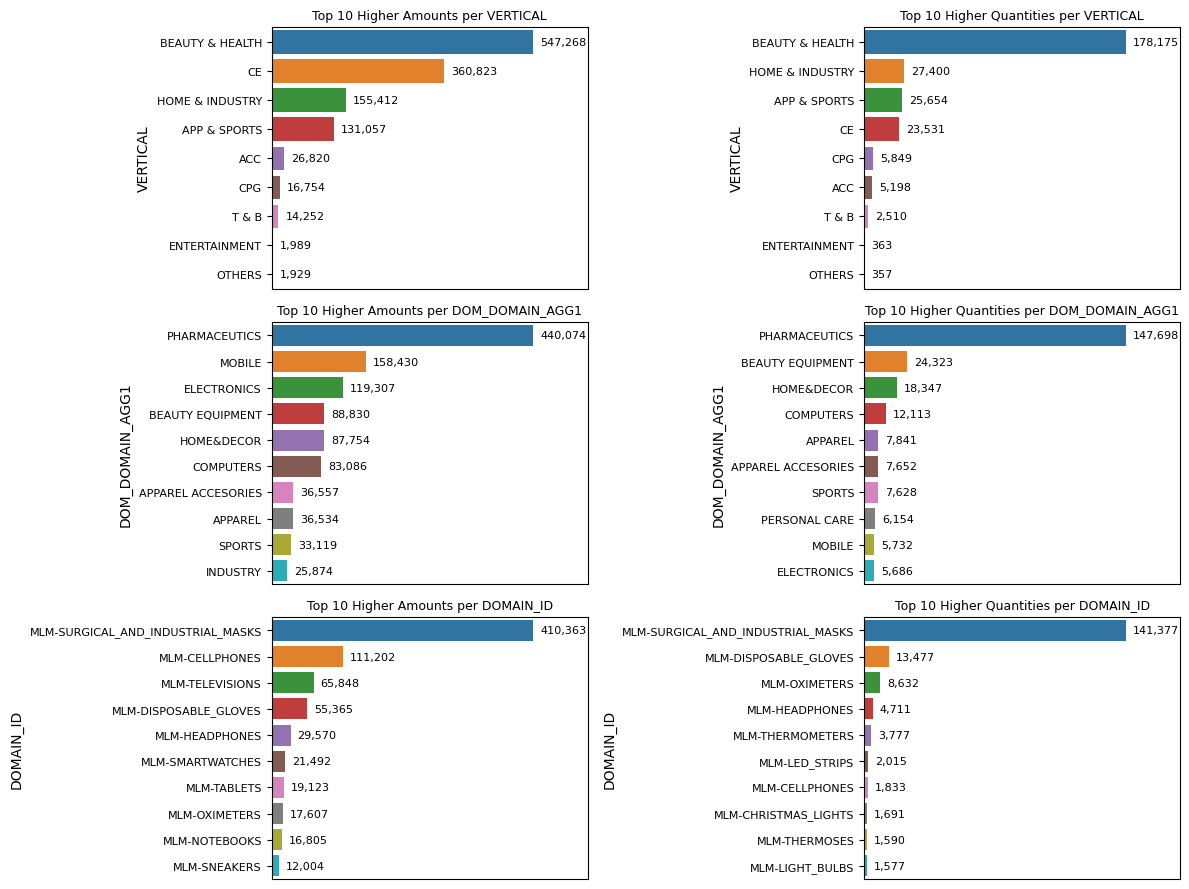

In [1018]:
# Definindo as features e a quantidade de gráficos
features = ['VERTICAL', 'DOM_DOMAIN_AGG1', 'DOMAIN_ID']
num_features = len(features)

# Configurando o número de subplots para 3 linhas e 2 colunas
fig, axes = plt.subplots(num_features, 2, figsize=(12, num_features * 3))  # Ajuste o tamanho conforme necessário

for i, feature in enumerate(features):
    # Agrupamento e agregação dos dados
    best_deals = df.groupby([feature]).agg(
        offer_median=("OFFER_HOURS", lambda x: x.median()),
        amount_max=("SOLD_AMOUNT", lambda x: x.sum()),
        quantity_max=("SOLD_QUANTITY", lambda x: x.sum())
    ).reset_index()

    # Gráfico para amount_max
    sns.barplot(
        data=best_deals.nlargest(10, 'amount_max'),  # Ordena pelo amount_max para os 10 maiores
        orient='h',
        x="amount_max",
        y=feature,
        ax=axes[i, 0],
        errorbar=None,
        hue=feature
    )

    # Ajustar limites do eixo X para aumentar o espaço para o texto
    xlim = axes[i, 0].get_xlim()  # Obter limites atuais
    axes[i, 0].set_xlim(0, xlim[1] * 1.15)  # Aumentar o limite superior em 15%

    # Adicionando os valores nas barras
    for p in axes[i, 0].patches:  # Para cada barra
        width = p.get_width()  # Largura da barra
        axes[i, 0].annotate(f'{width:,.0f}',  # Formatar o valor
                            (width + 5, p.get_y() + p.get_height() / 2),  # Posição x, y com um deslocamento maior
                            ha='left', va='center',  # Alinhamento
                            fontsize=8, color='black',  # Tamanho da fonte
                            xytext=(5, 0),  # Deslocamento do texto em relação à barra
                            textcoords='offset points')  # Coordenadas de deslocamento

    # Remover a escala do eixo inferior
    axes[i, 0].xaxis.set_visible(False)  # Torna o eixo X invisível
    axes[i, 0].set_title(f'Top 10 Higher Amounts per {feature}', size=9)  # Adiciona título ao gráfico amount_max
    axes[i, 0].tick_params(labelsize=8)  # Ajusta o tamanho da fonte dos ticks do eixo y

    # Gráfico para quantity_max
    sns.barplot(
        data=best_deals.nlargest(10, 'quantity_max'),  # Ordena pelo quantity_max para os 10 maiores
        orient='h',
        x="quantity_max",
        y=feature,
        ax=axes[i, 1],
        errorbar=None,
        hue=feature,
    )

    # Ajustar limites do eixo X para aumentar o espaço para o texto
    xlim = axes[i, 1].get_xlim()  # Obter limites atuais
    axes[i, 1].set_xlim(0, xlim[1] * 1.15)  # Aumentar o limite superior em 15%

    # Adicionando os valores nas barras
    for p in axes[i, 1].patches:  # Para cada barra
        width = p.get_width()  # Largura da barra
        axes[i, 1].annotate(f'{width:,.0f}',  # Formatar o valor
                            (width + 5, p.get_y() + p.get_height() / 2),  # Posição x, y com um deslocamento maior
                            ha='left', va='center',  # Alinhamento
                            fontsize=8, color='black',  # Tamanho da fonte
                            xytext=(5, 0),  # Deslocamento do texto em relação à barra
                            textcoords='offset points')  # Coordenadas de deslocamento

    # Remover a escala do eixo inferior
    axes[i, 1].xaxis.set_visible(False)  # Torna o eixo X invisível
    axes[i, 1].set_title(f'Top 10 Higher Quantities per {feature}', size=9)  # Adiciona título ao gráfico quantity_max
    axes[i, 1].tick_params(labelsize=8)  # Ajusta o tamanho da fonte dos ticks do eixo y

# Ajusta o layout para não sobrepor elementos
plt.subplots_adjust(hspace=0.4)  # Aumenta o espaço entre as linhas de gráficos
plt.tight_layout()
plt.show()

In [1022]:
# Agrupamento e agregação dos dados
df.groupby(['VERTICAL', 'DOM_DOMAIN_AGG1', 'DOMAIN_ID']).agg(
    offer_median=("OFFER_HOURS", lambda x: x.median()),
    amount_max=("SOLD_AMOUNT", lambda x: x.sum()),
    quantity_max=("SOLD_QUANTITY", lambda x: x.sum())
).reset_index()

VERTICAL DOM_DOMAIN_AGG1                    DOMAIN_ID  offer_median  \
0         ACC       ACC TOOLS             MLM-CAR_SCANNERS         6.000   
1         ACC       ACC TOOLS  MLM-HYDRAULIC_VEHICLE_JACKS         6.010   
2         ACC            AGRO      MLM-EAR_TAG_APPLICATORS         6.000   
3         ACC       AUTOPARTS              MLM-ABS_SENSORS         6.000   
4         ACC       AUTOPARTS    MLM-AUTOMOBILE_FUEL_PUMPS         6.000   
...       ...             ...                          ...           ...   
1261    T & B  TOYS AND GAMES    MLM-TOY_PRETEND_SUITCASES         6.000   
1262    T & B  TOYS AND GAMES               MLM-TOY_ROBOTS         6.000   
1263    T & B  TOYS AND GAMES         MLM-TOY_VIRTUAL_PETS         6.005   
1264    T & B  TOYS AND GAMES       MLM-TRADING_CARD_GAMES         6.000   
1265    T & B  TOYS AND GAMES              MLM-TRAMPOLINES         8.000   

      amount_max  quantity_max  
0         987.51         171.0  
1           0.00           0.0  
2           0.00           0.0  
3           0.00           0.0  
4           0.00           0.0  
...          ...           ...  
1261       10.03           2.0  
1262        0.00           0.0  
1263        0.00           0.0  
1264        0.00           0.0  
1265      673.96          11.0  

[1266 rows x 6 columns]

In [1038]:
# Agrupamento e agregação dos dados
df.groupby(['VERTICAL', 'DOM_DOMAIN_AGG1', 'DOMAIN_ID']).agg(
    offer_median=("OFFER_HOURS", lambda x: x.median()),
    amount_max=("SOLD_AMOUNT", lambda x: x.sum()),
    quantity_max=("SOLD_QUANTITY", lambda x: x.sum()),
    involved_stock=("INVOLVED_STOCK", lambda x: x.sum())
).reset_index().sort_values(ascending = False, by = "amount_max").head(20)

VERTICAL     DOM_DOMAIN_AGG1                          DOMAIN_ID  \
419  BEAUTY & HEALTH       PHARMACEUTICS  MLM-SURGICAL_AND_INDUSTRIAL_MASKS   
585               CE              MOBILE                     MLM-CELLPHONES   
566               CE         ELECTRONICS                    MLM-TELEVISIONS   
282  BEAUTY & HEALTH    BEAUTY EQUIPMENT              MLM-DISPOSABLE_GLOVES   
446               CE           COMPUTERS                     MLM-HEADPHONES   
599               CE              MOBILE                   MLM-SMARTWATCHES   
601               CE              MOBILE                        MLM-TABLETS   
304  BEAUTY & HEALTH    BEAUTY EQUIPMENT                      MLM-OXIMETERS   
459               CE           COMPUTERS                      MLM-NOTEBOOKS   
169     APP & SPORTS            FOOTWEAR                       MLM-SNEAKERS   
970  HOME & INDUSTRY            SECURITY           MLM-SURVEILLANCE_CAMERAS   
834  HOME & INDUSTRY          HOME&DECOR                     MLM-LED_STRIPS   
420  BEAUTY & HEALTH       PHARMACEUTICS                   MLM-THERMOMETERS   
411  BEAUTY & HEALTH       PHARMACEUTICS           MLM-OXYGEN_CONCENTRATORS   
148     APP & SPORTS  APPAREL ACCESORIES                     MLM-SUNGLASSES   
911  HOME & INDUSTRY            INDUSTRY         MLM-CARD_PAYMENT_TERMINALS   
98      APP & SPORTS             APPAREL                          MLM-PANTS   
306  BEAUTY & HEALTH    BEAUTY EQUIPMENT    MLM-PORTABLE_ELECTRIC_MASSAGERS   
729  HOME & INDUSTRY          HOME&DECOR                     MLM-BED_SHEETS   
218     APP & SPORTS              SPORTS                  MLM-GYM_DUMBBELLS   

     offer_median  amount_max  quantity_max  involved_stock  
419           6.0   410363.30      141377.0          651780  
585           8.0   111201.81        1833.0           44809  
566           8.0    65848.41         571.0           15456  
282           6.0    55365.39       13477.0           44825  
446           6.0    29570.35        4711.0           28067  
599           6.0    21492.10        1412.0           13501  
601           8.0    19123.19         476.0            6815  
304           6.0    17606.61        8632.0          116024  
459           8.0    16804.86          90.0            2481  
169           6.0    12004.28        1023.0           11754  
970           6.0    10298.34        1114.0            5761  
834           6.0     9858.15        2015.0            7401  
420           6.0     9504.12        3777.0           34056  
411           8.0     8936.75          63.0             319  
148           6.0     7992.00        1506.0            9648  
911           8.0     7465.46         715.0            1450  
98            6.0     7226.43        1153.0           14620  
306           6.0     6919.43         521.0            2309  
729           6.0     6541.12        1304.0           13269  
218           6.0     5989.49         528.0            9467

In [1040]:
df

OFFER_START_DATE          OFFER_START_DTTM         OFFER_FINISH_DTTM  \
0           2021-06-22 2021-06-22 16:00:00+00:00 2021-06-22 23:02:43+00:00   
1           2021-06-22 2021-06-22 13:00:00+00:00 2021-06-22 19:00:02+00:00   
2           2021-06-22 2021-06-22 07:00:00+00:00 2021-06-22 13:00:01+00:00   
3           2021-06-22 2021-06-22 19:00:00+00:00 2021-06-23 01:36:12+00:00   
4           2021-06-22 2021-06-22 13:00:00+00:00 2021-06-22 15:48:12+00:00   
...                ...                       ...                       ...   
47815       2021-06-19 2021-06-19 13:00:00+00:00 2021-06-19 19:00:01+00:00   
47816       2021-06-19 2021-06-19 13:00:00+00:00 2021-06-19 19:00:01+00:00   
47817       2021-06-19 2021-06-19 07:00:00+00:00 2021-06-19 13:00:03+00:00   
47818       2021-06-19 2021-06-19 13:00:00+00:00 2021-06-19 19:00:00+00:00   
47819       2021-06-19 2021-06-19 13:00:00+00:00 2021-06-19 19:00:00+00:00   

       OFFER_HOURS  MONTH      OFFER_TYPE  INVOLVED_STOCK  \
0             7.05      6  lightning_deal               4   
1             6.00      6  lightning_deal               5   
2             6.00      6  lightning_deal              15   
3             6.60      6  lightning_deal              15   
4             2.80      6  lightning_deal              15   
...            ...    ...             ...             ...   
47815         6.00      6  lightning_deal              15   
47816         6.00      6  lightning_deal               5   
47817         6.00      6  lightning_deal               5   
47818         6.00      6  lightning_deal               5   
47819         6.00      6  lightning_deal              15   

       REMAINING_STOCK_AFTER_END  SOLD_AMOUNT  SOLD_QUANTITY   ORIGIN  \
0                             -2         4.72            6.0        A   
1                              5         0.00            0.0  unknown   
2                             12        10.73            3.0  unknown   
3                             13         7.03            2.0  unknown   
4                              0        39.65           15.0  unknown   
...                          ...          ...            ...      ...   
47815                          9        16.28            6.0  unknown   
47816                          5         0.00            0.0  unknown   
47817                          3        16.62            2.0  unknown   
47818                          1        38.79            4.0  unknown   
47819                         15         0.00            0.0  unknown   

      SHIPPING_PAYMENT_TYPE DOM_DOMAIN_AGG1         VERTICAL  \
0                      none       PETS FOOD              CPG   
1             free_shipping    PET PRODUCTS           OTHERS   
2                      none       COMPUTERS               CE   
3                      none       COMPUTERS               CE   
4                      none       COMPUTERS               CE   
...                     ...             ...              ...   
47815                  none      HOME&DECOR  HOME & INDUSTRY   
47816         free_shipping      HOME&DECOR  HOME & INDUSTRY   
47817         free_shipping      HOME&DECOR  HOME & INDUSTRY   
47818         free_shipping      HOME&DECOR  HOME & INDUSTRY   
47819         free_shipping      HOME&DECOR  HOME & INDUSTRY   

                            DOMAIN_ID  difference  unit_price  \
0                      MLM-BIRD_FOODS           6    0.786667   
1         MLM-ANIMAL_AND_PET_PRODUCTS           0    4.117500   
2                        MLM-SPEAKERS           3    3.576667   
3                      MLM-HEADPHONES           2    3.515000   
4                      MLM-HEADPHONES          15    2.643333   
...                               ...         ...         ...   
47815            MLM-CHRISTMAS_LIGHTS           6    2.713333   
47816        MLM-DECORATIVE_PAINTINGS           0    3.780000   
47817  MLM-INDOOR_CURTAINS_AND_BLINDS           2    8.310000   
47818  MLM-INDOOR_CURTAINS_AND_BLINDS   